In [1]:
import pandas as pd
import matplotlib.pyplot as plt


Bad key text.latex.unicode in file /Users/maxfrax/anaconda3/envs/default/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key text.latex.preview in file /Users/maxfrax/anaconda3/envs/default/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 125 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/maxfrax/anaconda3/envs/default/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 157 ('mathtext.fallback_to_cm : True

# Evaluation

Article Source: A Comparative Evaluation of Unsupervised Anomaly Detection Algorithms for Multivariate Data 
Goldstein M, Uchida S (2016) A Comparative Evaluation of Unsupervised Anomaly Detection Algorithms for Multivariate Data. PLOS ONE 11(4): e0152173. https://doi.org/10.1371/journal.pone.0152173

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OPQMVF

I'm going to test the following dataset:
1. Pen-Global
1. Pen-Local
1. Speech
1. Aloi

On the following metrics: ROC-AUC

## Pen-Global Dataset

Paper version: https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/OPQMVF/KQYDN9&version=1.0

Original UCI: https://archive.ics.uci.edu/ml/datasets/Pen-Based%20Recognition%20of%20Handwritten%20Digits

In [2]:
input_names = []

for i in range(8):
    input_names.append(f'x{i}')
    input_names.append(f'y{i}')

data = pd.read_csv('/Users/maxfrax/Downloads/pen-global-unsupervised-ad.csv', names=input_names+['outlier'])
data = data.sample(frac=1)

In [3]:
X = data[input_names]
y = data['outlier'] == 'o'

y = [-1 if v else 1 for v in y]


### Normalization

In the paper the declare they scale all their datasets with MinMax (Normalization section)

In [4]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(X, columns=input_names)

Let's plot the first number to show we understood the dataset correctly. As we can see the plot shows the number 8, which is expected since the normal class is just the number 8.

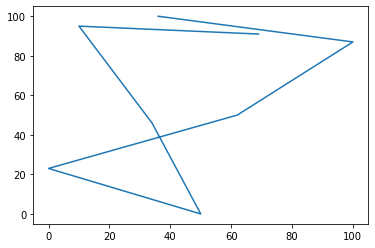

507    n
Name: outlier, dtype: object

In [5]:
xs = []
ys = []

for i, v in enumerate(data[input_names][0:1].values[0]):
    if i % 2 == 0:
        xs.append(v)
    else:
        ys.append(v)
        
plt.plot(xs, ys)
plt.show()

data[0:1]['outlier']

### Replicating: One Class SVM

I'm going to use sklearn implementation https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html since both the paper and sklearn refer to:

Estimating the support of a high-dimensional distribution Schölkopf, Bernhard, et al. Neural computation 13.7 (2001): 1443-1471.

In the paper they use OneClassSVM in an unsupervised setting.

> In the unsupervised anomaly detection scenario, the one-class SVM is trained using the dataset and afterwards, each instance in the dataset is scored by a normalized distance to the determined decision boundary [40]. The parameter ν needs to be set to a value lager than zero such that the contained anomalies are correctly handled by a soft-margin

The hyper parameters tested are 0.2 < v < 0.8 and automatic tuning for the Gaussian kernel.
By automatic tuning I guess they talk about trial and error. In fact they declare it as a computationally hard task.

610
0.9708082212950085
{'gamma': 5.921994182304879, 'nu': 0.9039647521118852}


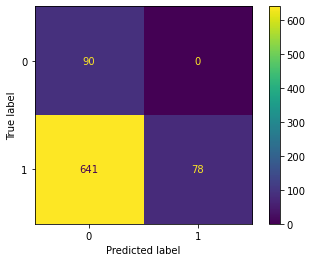

In [6]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import uniform
from sklearn.model_selection import PredefinedSplit

# Gamma is a free parameter. It ranges from 0 to infinity
# Predefined split to train on the whole dataset and test on the whole dataset
distributions = dict(nu=uniform(loc=0.2, scale=0.8), gamma=uniform(loc=0, scale=1000))

test_fold = [0 if v < len(X) else 1 for v in range(len(X) * 2)]

search = RandomizedSearchCV(OneClassSVM(), distributions, cv=PredefinedSplit(test_fold=test_fold), refit=True, n_iter=1000, scoring='roc_auc', n_jobs=-1, error_score='raise')

res = search.fit(pd.concat([X,X]), y+y)

clf = res.best_estimator_

print(res.best_index_)
print(res.best_score_)
print(res.best_params_)


y_pred = clf.predict(X)

ConfusionMatrixDisplay(confusion_matrix(y, y_pred)).plot()
plt.show()

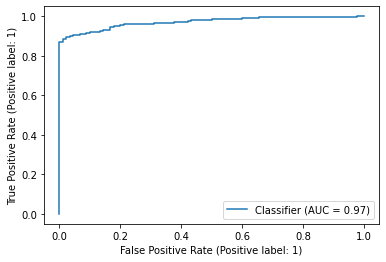

In [8]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y, clf.score_samples(X))

plt.show()

In [9]:
# TODO come mai il valore della roc curve è peggio di quelli del training?
# Sto scegliendo gli iperparametri trainando e testando su tutto il dataset.
cv_results = pd.DataFrame(res.cv_results_)

cv_results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_nu,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
610,0.072435,0.001533,0.102872,0.001299,5.921994,0.903965,"{'gamma': 5.921994182304879, 'nu': 0.903964752...",0.970808,0.970808,0.970808,0.0,1
595,0.062999,0.003756,0.088885,0.004241,6.145953,0.710915,"{'gamma': 6.14595296837539, 'nu': 0.7109145980...",0.960454,0.960454,0.960454,0.0,2
218,0.062297,0.007578,0.104307,0.004323,8.170006,0.864242,"{'gamma': 8.17000638174681, 'nu': 0.8642421899...",0.949251,0.949251,0.949251,0.0,3
378,0.045387,0.004247,0.052386,0.002953,3.209377,0.422458,"{'gamma': 3.209377470656416, 'nu': 0.422457832...",0.942837,0.942837,0.942837,0.0,4
632,0.054412,0.000440,0.089987,0.004328,7.177927,0.657489,"{'gamma': 7.177926857044659, 'nu': 0.657488885...",0.934400,0.934400,0.934400,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
416,0.055878,0.003065,0.095256,0.020606,932.400791,0.672931,"{'gamma': 932.4007910612743, 'nu': 0.672931197...",0.408353,0.408353,0.408353,0.0,996
244,0.064408,0.003552,0.098712,0.005330,41.597488,0.671028,"{'gamma': 41.597488002328205, 'nu': 0.67102774...",0.407480,0.407480,0.407480,0.0,997
359,0.064281,0.005252,0.112309,0.019712,66.837282,0.964027,"{'gamma': 66.83728188726879, 'nu': 0.964026699...",0.400495,0.400495,0.400495,0.0,998
345,0.055764,0.006129,0.110429,0.008544,53.592595,0.932813,"{'gamma': 53.59259516086268, 'nu': 0.932812796...",0.324154,0.324154,0.324154,0.0,999


### My Algorithm: BSVClassifier

### Federated Learning: BSVClassifier